In [ ]:
#hide
!pip install -Uqq fastbook
!pip install fastai==2.5
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 187 kB 30.0 MB/s 
     |████████████████████████████████| 1.2 MB 11.2 MB/s 
     |████████████████████████████████| 49 kB 1.6 MB/s 
     |████████████████████████████████| 56 kB 1.6 MB/s 
     |████████████████████████████████| 51 kB 129 kB/s 
     |████████████████████████████████| 561 kB 38.4 MB/s 
     |████████████████████████████████| 130 kB 24.1 MB/s 
     |████████████████████████████████| 188 kB 6.1 MB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 831.4 MB 6.9 kB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
     |████████████████████████████████| 23.2 MB 1.6 MB/s 
     |████████████████████████████████| 23.3 MB 1.6 MB/s 
     |████████████████████████████████| 23.3 MB 51.1 MB/s 
     |████████████████████████████████| 22.1 MB 1.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu11

In [ ]:
#hide
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *

Vamos a crear un dataset con imagenes de balones para entrenar nuestro modelo. Para ello nos ayudamos de DuckDuckGo.
(En mi caso, la descarga de las imagenes daba error al encontrar una URL no valida y opte por crear el dataset a mano, poniendo en el 40 imagenes de cada tipo de balon)

In [ ]:
ball_types = 'basket','soccer','american football'
path = Path('balls')

In [ ]:
if not path.exists():
  path.mkdir()
  for o in ball_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o} ball', max_images=40)
    cont = 0
    for i in results:
      download_url(i, str(dest) + "/" + str(cont) + ".jpg")
      cont += 1

HTTPError: ignored

In [ ]:
fns = get_image_files(path)
fns

(#120) [Path('balls/soccer/11.jpg'),Path('balls/soccer/10.jpg'),Path('balls/soccer/18.jpg'),Path('balls/soccer/33.jpg'),Path('balls/soccer/1.jpg'),Path('balls/soccer/38.jpg'),Path('balls/soccer/20.jpg'),Path('balls/soccer/5.jpg'),Path('balls/soccer/4.jpg'),Path('balls/soccer/28.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#0) []

In [ ]:
failed.map(Path.unlink);

Una ve

In [ ]:
balls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = balls.dataloaders(path)

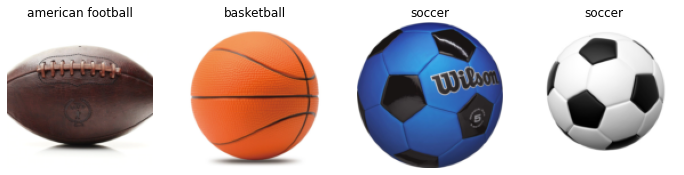

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

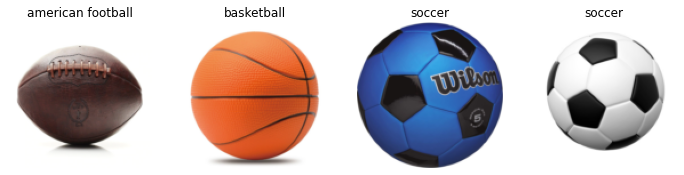

In [ ]:
balls = balls.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = balls.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

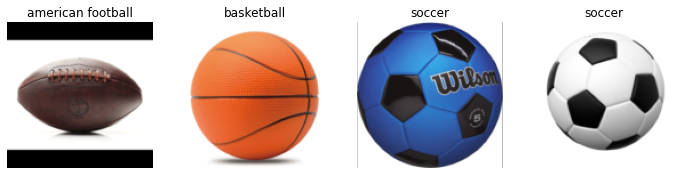

In [ ]:
balls = balls.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = balls.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

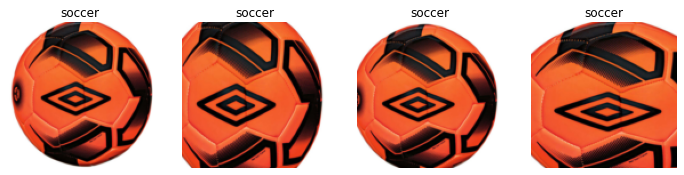

In [ ]:
balls = balls.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = balls.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

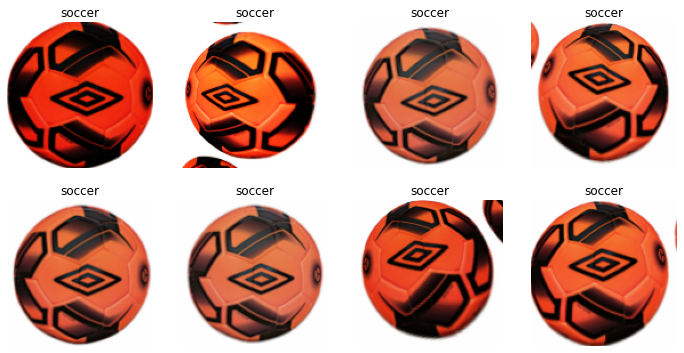

In [ ]:
balls = balls.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = balls.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
balls = balls.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = balls.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

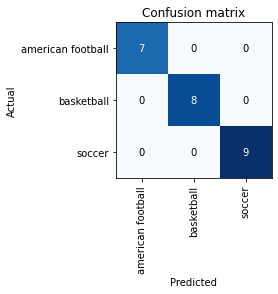

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

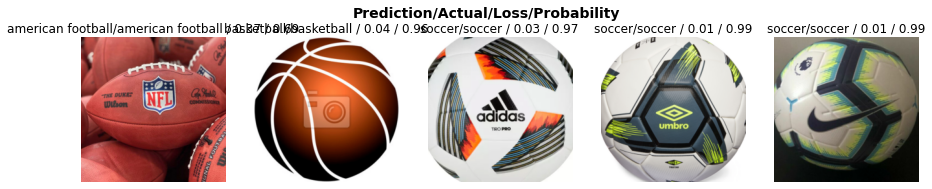

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
learn.export()

In [ ]:
path = Path('/content/gdrive/MyDrive/')
path.ls(file_exts='.pkl')

(#1) [Path('/content/gdrive/MyDrive/export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('/content/balon1.jpg')

('american football', tensor(0), tensor([9.9910e-01, 2.9750e-04, 6.0469e-04]))

In [ ]:
learn_inf.dls.vocab

['american football', 'basketball', 'soccer']

In [ ]:
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [ ]:
def on_click(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediccion: {pred}; Probabilidad: {probs[pred_idx]:.04f}'

In [ ]:
btn_upload.observe(on_click, names=['data'])

In [ ]:
display(VBox([widgets.Label('Selecciona tu balon!'), btn_upload, out_pl, lbl_pred]))